(quickstart)=

# ArviZ Quickstart

In [1]:
import arviz as az
import numpy as np

## ArviZ style sheets


In [2]:
# ArviZ ships with style sheets!
az.style.use("arviz-darkgrid")

Feel free to check the examples of style sheets {ref}` here <example_styles>`.

## Get started with plotting

ArviZ is designed to be used with libraries like [PyStan](https://pystan.readthedocs.io) and [PyMC3](https://docs.pymc.io), but works fine with raw NumPy arrays.

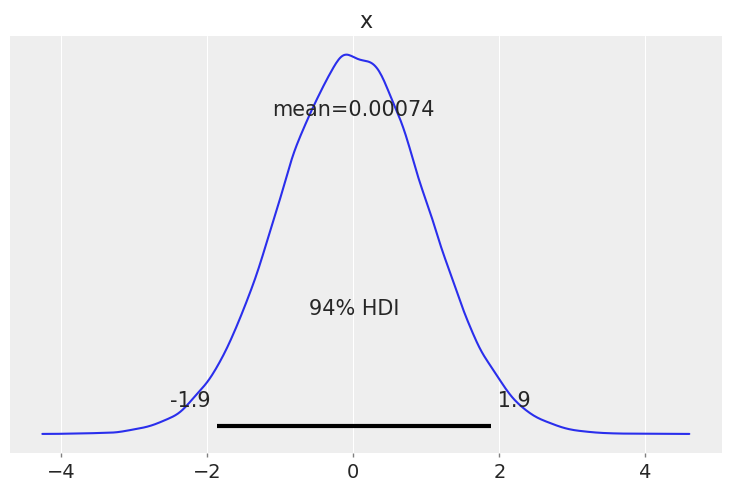

In [3]:
az.plot_posterior(np.random.randn(100_000));

Plotting a dictionary of arrays, ArviZ will interpret each key as the name of a different random variable. Each row of an array is treated as an independent series of draws from the variable, called a _chain_. Below, we have 10 chains of 50 draws, each for four different distributions.

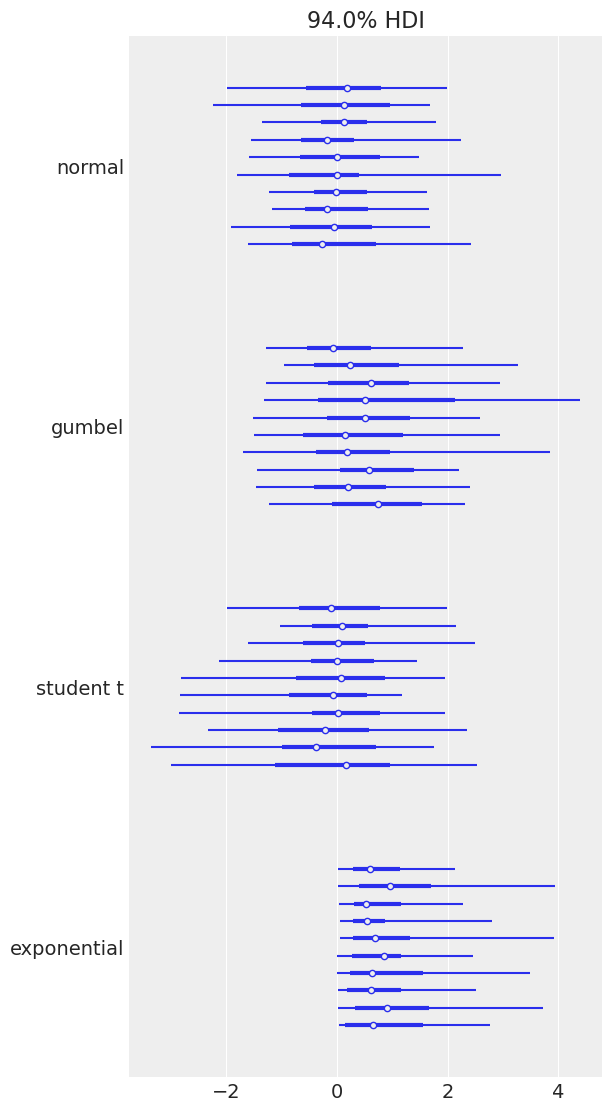

In [4]:
size = (10, 50)
az.plot_forest(
    {
        "normal": np.random.randn(*size),
        "gumbel": np.random.gumbel(size=size),
        "student t": np.random.standard_t(df=6, size=size),
        "exponential": np.random.exponential(size=size),
    }
);

## ArviZ rcParams

You may have noticed that for both {func}`~arviz.plot_posterior` and {func}`~arviz.plot_forest`, the Highest Density Interval (HDI) is 94%, which you may find weird at first. This particular value is a friendly reminder of the arbitrary nature of choosing any single value without further justification, including common values like 95%, 50% and even our own default, 94%. ArviZ includes default values for a few parameters, you can access them with `az.rcParams`. To change the default HDI value to let's say 90% you can do:

In [5]:
az.rcParams['stats.hdi_prob'] = 0.90

In [6]:
import pymc3 as pm

J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

In [7]:
with pm.Model() as centered_eight:
    mu = pm.Normal("mu", mu=0, sd=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sd=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sd=sigma, observed=y)

    # This pattern is useful in PyMC3
    prior = pm.sample_prior_predictive()
    centered_eight_trace = pm.sample(return_inferencedata=False)
    posterior_predictive = pm.sample_posterior_predictive(centered_eight_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6793567391371191, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Most ArviZ functions work fine with `trace` objects from PyMC3:

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yilinxia/opt/miniconda3/envs/arviz/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


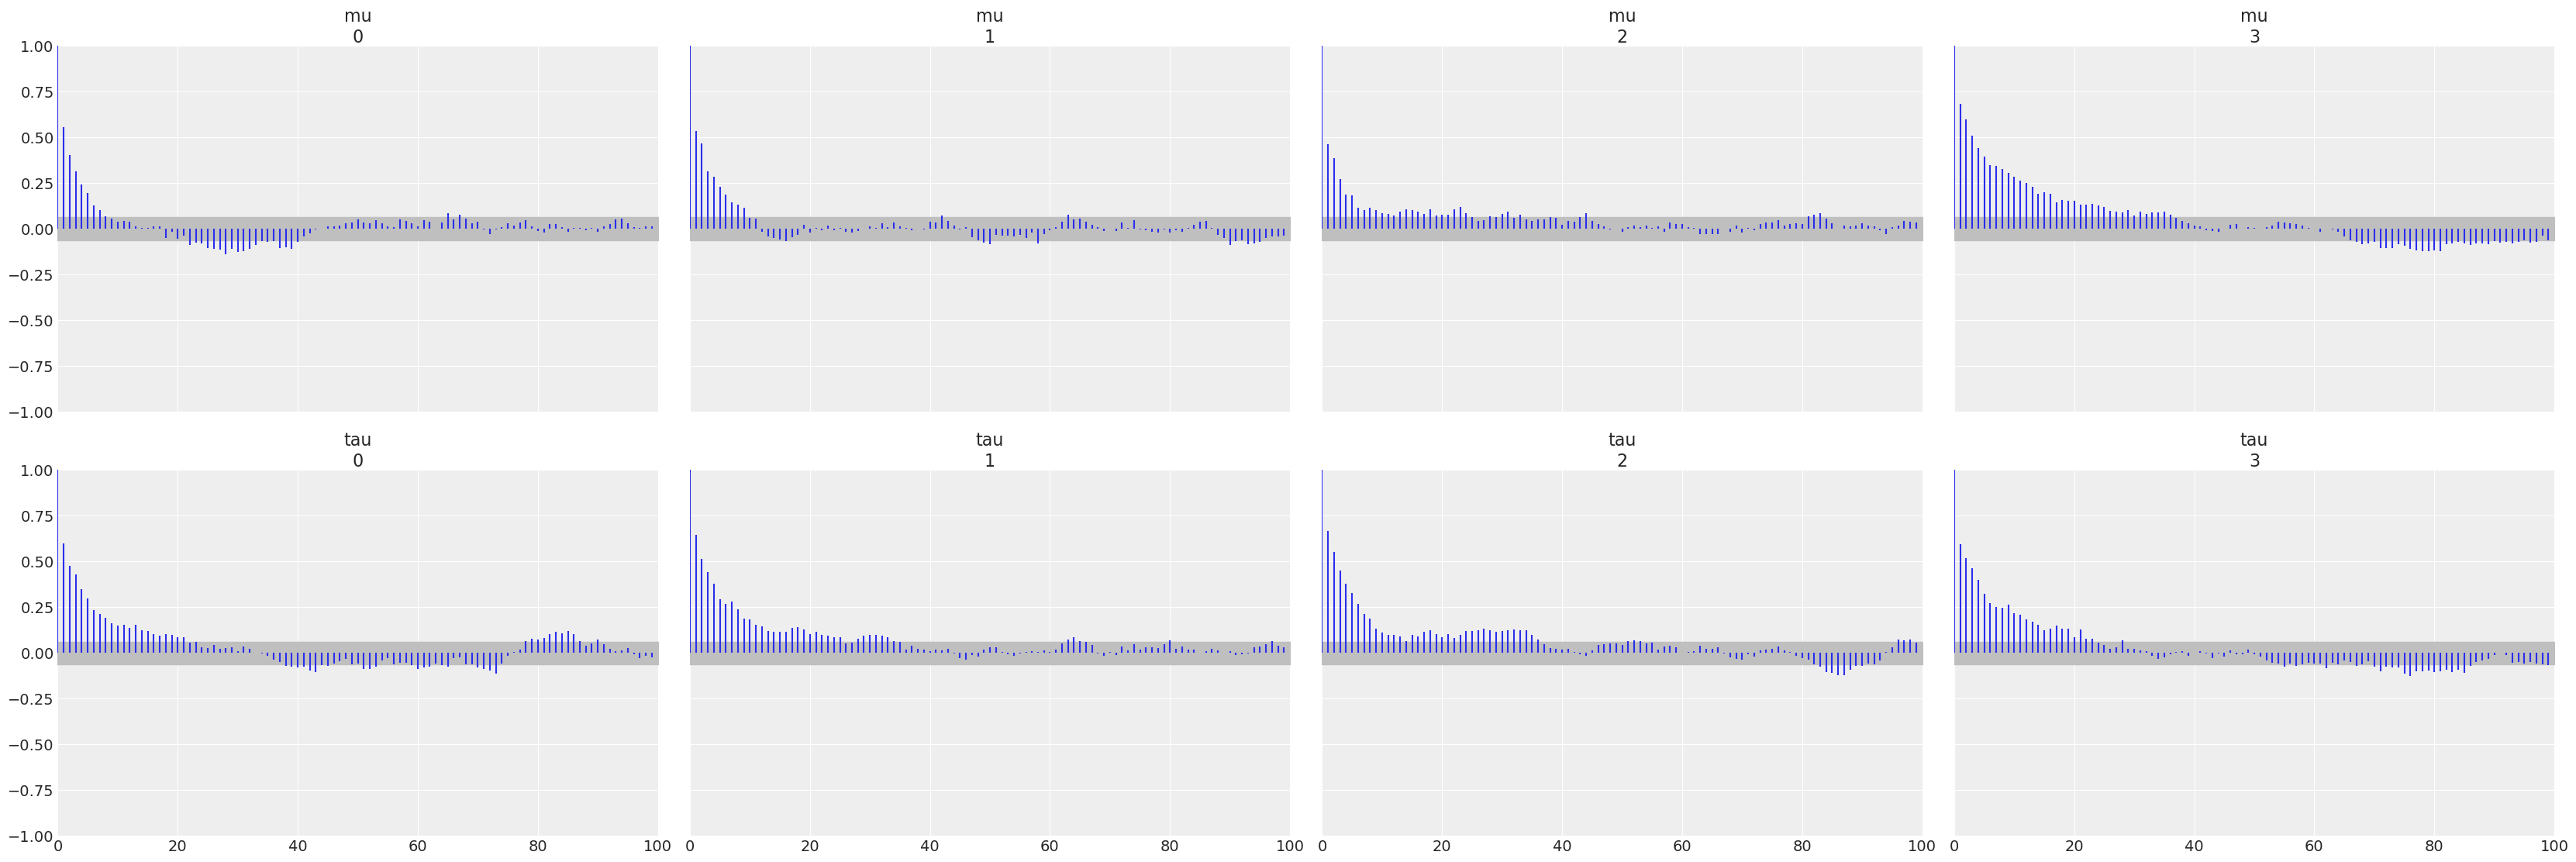

In [8]:
az.plot_autocorr(centered_eight_trace, var_names=["mu", "tau"]);

### Convert to InferenceData

For much more powerful querying, analysis and plotting, we can use built-in ArviZ utilities to convert PyMC3 objects to xarray datasets. Note we are also giving some information about labelling.

ArviZ is built to work with {ref}`InferenceData <creating_InferenceData>`. The more *groups* it has access to, the more powerful analyses it can perform. You can check the `InferenceData` structure specification {ref}`here <schema>`. Given below is a plot of the trace, which is common in PyMC3 workflows. Don't forget to note the intelligent labels.

In [9]:
data = az.from_pymc3(
    trace=centered_eight_trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    model=centered_eight,
    coords={"school": schools},
    dims={"theta": ["school"], "obs": ["school"]},
)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

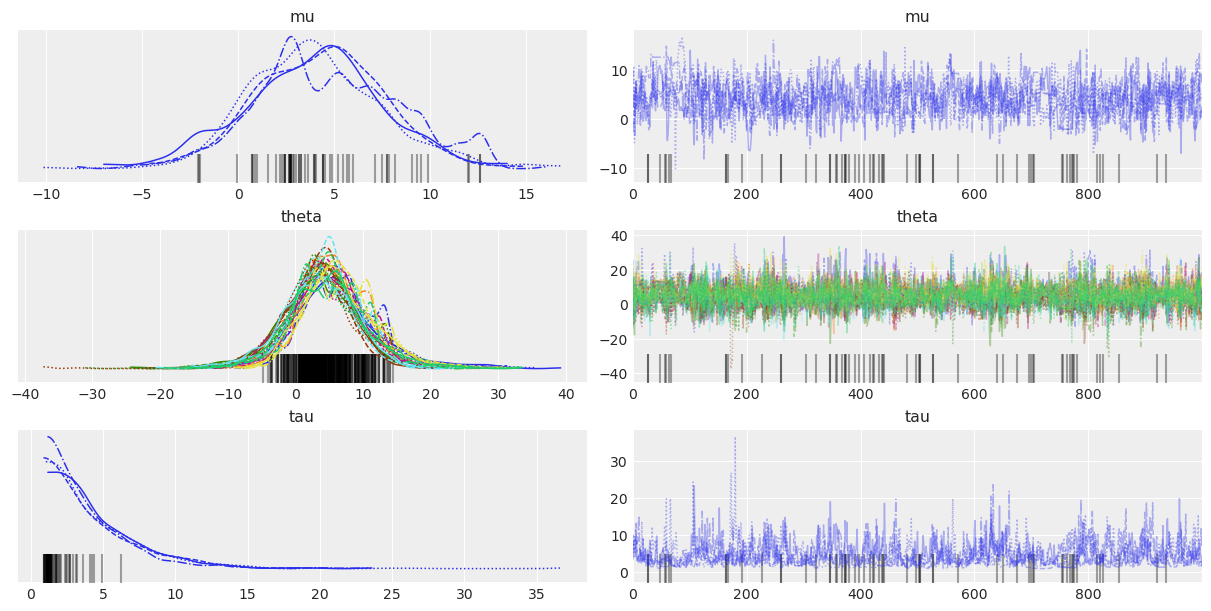

In [10]:
az.plot_trace(data);

## Plotting with PyStan objects

ArviZ is built with first class support for [PyStan](https://pystan.readthedocs.io/en/latest/) objects, and can plot raw `fit` objects in a reasonable manner. Here is the same centered eight schools model:

In [11]:
import nest_asyncio
nest_asyncio.apply()

In [12]:
import stan  # pystan version 3.4.0


schools_code = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

schools_dat = {
    "J": 8,
    "y": [28, 8, -3, 7, -1, 1, 18, 12],
    "sigma": [15, 10, 16, 11, 9, 11, 10, 18],
}

posterior = stan.build(schools_code, data=schools_dat, random_seed=1)
fit = posterior.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/28/kcwvvd8j31n3160270pbl55c0000gn/T/httpstan_z40qsbap/model_rhg5bfgj.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/28/kcwvvd8j31n3160270pbl55c0000gn/T/httpstan_z40qsbap/model_rhg5bfgj.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/28/kcwvvd8j31n3160270pbl55c0000gn/T/httpstan_z40qsbap/model_rhg5bfgj.stan', line 11, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will 

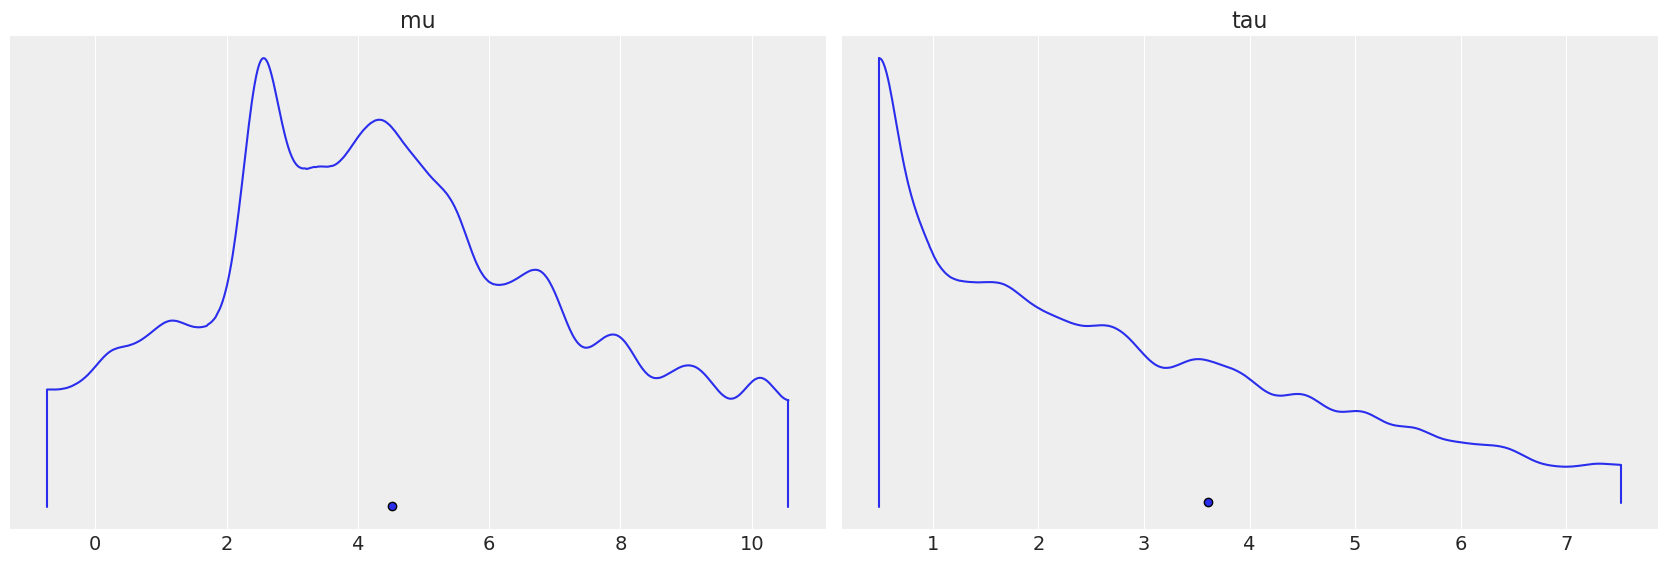

In [13]:
az.plot_density(fit, var_names=["mu", "tau"]);

Again, converting to `InferenceData` (a {ref}`netCDF <netcdf>` datastore that loads data into `xarray` datasets), we can get much richer labelling and mixing of data. Here is a plot showing where the Hamiltonian sampler had divergences:

In [14]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive="y_hat",
    observed_data=["y"],
    log_likelihood={"y": "log_lik"},
    coords={"school": schools},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

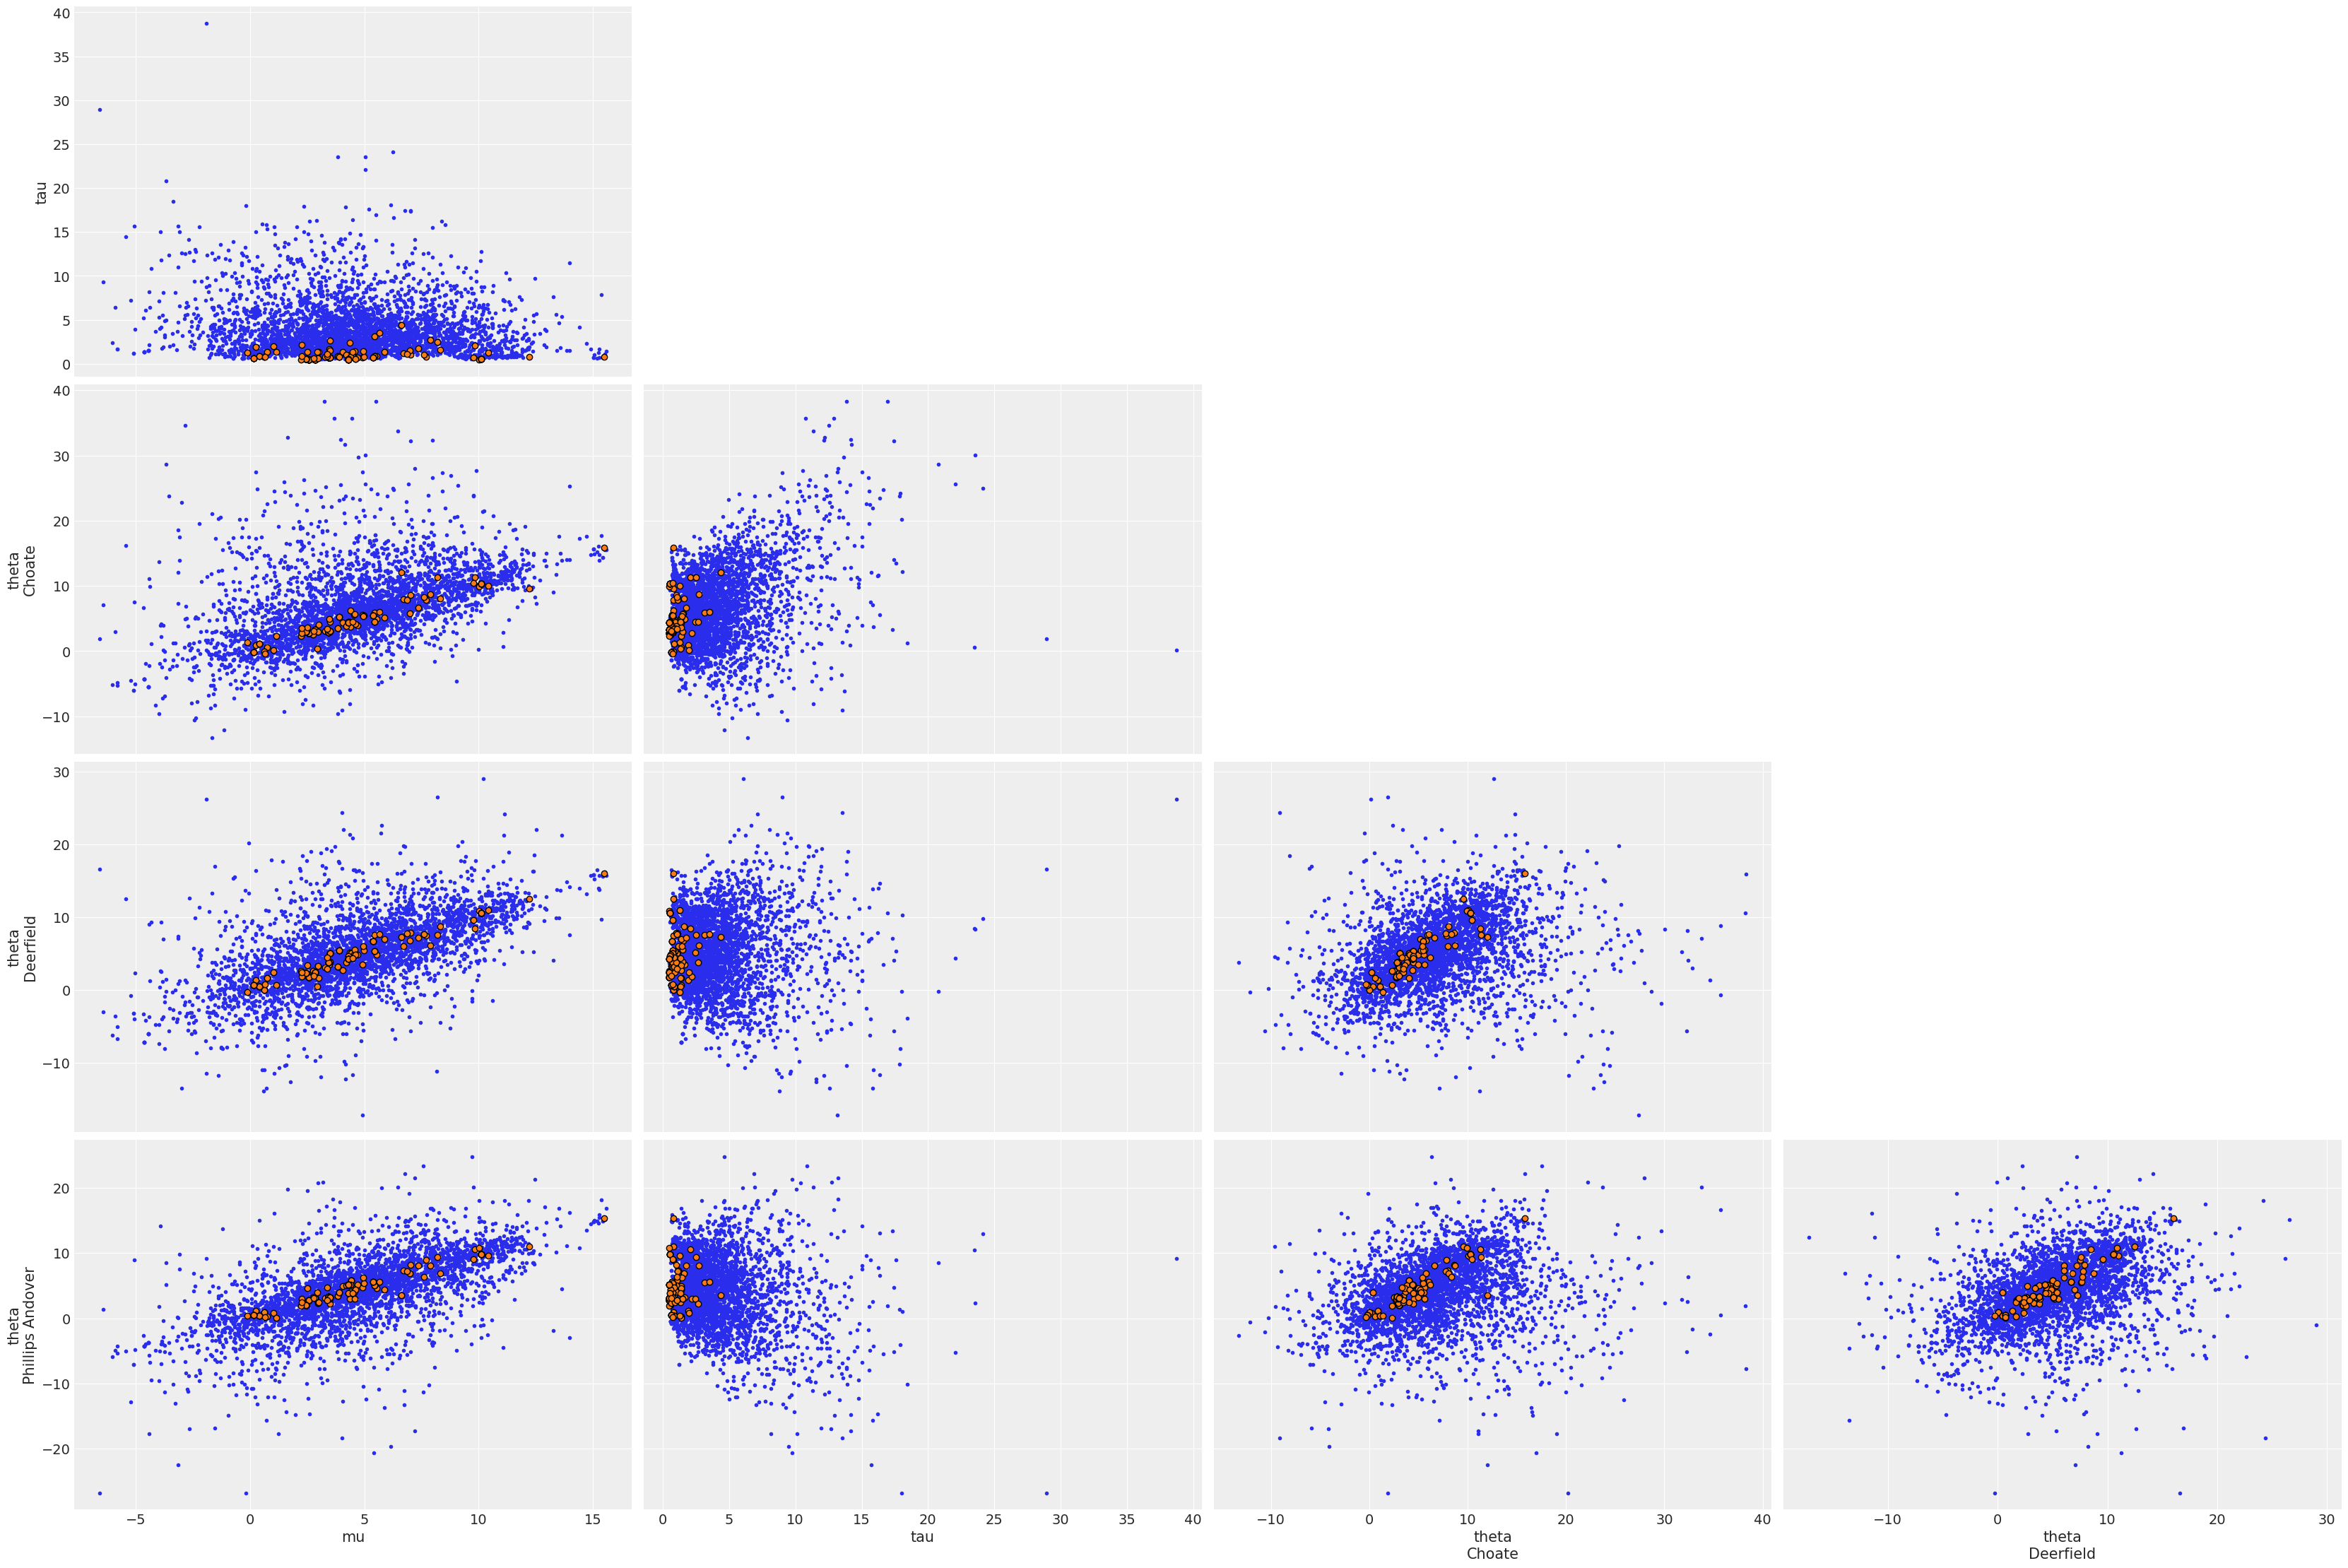

In [15]:
az.plot_pair(
    data,
    coords={"school": ["Choate", "Deerfield", "Phillips Andover"]},
    divergences=True,
);

:::{seealso}
working_with_InferenceData
:::